# A Diet that Helps: What is Good Food?

## 📖 Background
You and your friend have gotten into a debate about nutrition. Your friend follows a high-protein diet and does not eat any carbohydrates (no grains, no fruits). You claim that a balanced diet should contain all nutrients but should be low in calories. Both of you quickly realize that most of what you know about nutrition comes from mainstream and social media.

Being the data scientist that you are, you offer to look at the data yourself to answer a few key questions.

## 💾 The data

You source nutrition data from USDA's FoodData Central [website](https://fdc.nal.usda.gov/download-datasets.html). This data contains the calorie content of 7,793 common foods, as well as their nutritional composition. Each row represents one food item, and nutritional values are based on a 100g serving. Here is a description of the columns:

- **FDC_ID**: A unique identifier for each food item in the database.
- **Item**: The name or description of the food product.
- **Category**: The category or classification of the food item, such as "Baked Products" or "Vegetables and Vegetable Products".
- **Calories**: The energy content of the food, presented in kilocalories (kcal).
- **Protein**: The protein content of the food, measured in grams.
- **Carbohydrate**: The carbohydrate content of the food, measured in grams.
- **Total fat**: The total fat content of the food, measured in grams.
- **Cholesterol**: The cholesterol content of the food, measured in milligrams.
- **Fiber**: The dietary fiber content of the food, measured in grams.
- **Water**: The water content of the food, measured in grams.
- **Alcohol**: The alcohol content of the food (if any), measured in grams.
- **Vitamin C**: The Vitamin C content of the food, measured in milligrams.

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# Load csv file using Panda
df = pd.read_csv('nutrition.csv')

# Check first few rows of the data set
df.head()

,FDC_ID,Item,Category,Calories,Protein,Carbohydrate,Total fat,Cholesterol,Fiber,Water,Alcohol,Vitamin C
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0 kcal,5.88 g,41.18 g,13.24 g,0.0 mg,1.2 g,35.5 g,NaN,NaN
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0 kcal,4.34 g,53.42 g,11.27 g,0.0 mg,1.4 g,27.86 g,NaN,0.1 mg
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0 kcal,6.1 g,79.8 g,3.7 g,NaN,NaN,3.2 g,NaN,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0 kcal,8.0 g,46.0 g,1.8 g,NaN,NaN,42.6 g,NaN,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0 kcal,6.58 g,41.05 g,9.22 g,15.0 mg,2.2 g,40.34 g,0.0 g,0.0 mg


# Executive Summary



# Data Cleaning

In [4]:
#Check data type for each column, and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793 entries, 0 to 7792
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FDC_ID        7793 non-null   int64 
 1   Item          7793 non-null   object
 2   Category      7793 non-null   object
 3   Calories      7793 non-null   object
 4   Protein       7793 non-null   object
 5   Carbohydrate  7793 non-null   object
 6   Total fat     7793 non-null   object
 7   Cholesterol   7394 non-null   object
 8   Fiber         7231 non-null   object
 9   Water         7793 non-null   object
 10  Alcohol       5399 non-null   object
 11  Vitamin C     7332 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.7+ KB


In [5]:
# Clean data and convert data type
df["Calories"] = df["Calories"].str.strip(" kcal").astype(float)
df["Protein"] = df["Protein"].str.strip(" g").astype(float)
df["Carbohydrate"] =  df["Carbohydrate"].str.strip(" g").astype(float)
df["Total fat"] = df["Total fat"].str.strip(" g").astype(float)
df["Cholesterol"] = df["Cholesterol"].str.strip(" mg").astype(float)
df["Fiber"] = df["Fiber"].str.strip(" g").astype(float)
df["Water"] = df["Water"].str.strip(" g").astype(float)
df["Alcohol"] = df["Alcohol"].str.strip(" g").astype(float)
df["Vitamin C"] = df["Vitamin C"].str.strip(" mg").astype(float)

In [6]:
# Rename column to add measurement unit, and remove space (because to write SQL queries, column name must contain no space)
df = df.rename(columns={
    'Calories': 'Calories_kcal', 
    'Protein': 'Protein_g', 
    'Carbohydrate': 'Carbohydrate_g',
    'Total fat': 'TotalFat_g',
    'Cholesterol': 'Cholesterol_mg',
    'Fiber': 'Fiber_g',
    'Water': 'Water_g',
    'Alcohol': 'Alcohol_g',    
    'Vitamin C': 'VitaminC_mg', 
    
})

In [7]:
# Check number of null values in each column
print(df.isnull().sum())

# Replace null with median of non-null values
columns_to_fill = ["Cholesterol_mg", "Fiber_g", "Alcohol_g", "VitaminC_mg"]
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna(col.dropna().median()))

df.head()

FDC_ID               0
Item                 0
Category             0
Calories_kcal        0
Protein_g            0
Carbohydrate_g       0
TotalFat_g           0
Cholesterol_mg     399
Fiber_g            562
Water_g              0
Alcohol_g         2394
VitaminC_mg        461
dtype: int64


,FDC_ID,Item,Category,Calories_kcal,Protein_g,Carbohydrate_g,TotalFat_g,Cholesterol_mg,Fiber_g,Water_g,Alcohol_g,VitaminC_mg
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Baked Products,307.0,5.88,41.18,13.24,0.0,1.2,35.50,0.0,0.0
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",Baked Products,330.0,4.34,53.42,11.27,0.0,1.4,27.86,0.0,0.1
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",Baked Products,377.0,6.10,79.80,3.70,8.0,0.3,3.20,0.0,0.0
3,167515,"George Weston Bakeries, Thomas English Muffins",Baked Products,232.0,8.00,46.00,1.80,8.0,0.3,42.60,0.0,0.0
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",Baked Products,273.0,6.58,41.05,9.22,15.0,2.2,40.34,0.0,0.0


In [8]:
# Data description should include objects because apart from the ID column, the rest contain objects
df.describe(include=['object', 'number'])

,FDC_ID,Item,Category,Calories_kcal,Protein_g,Carbohydrate_g,TotalFat_g,Cholesterol_mg,Fiber_g,Water_g,Alcohol_g,VitaminC_mg
count,7793.000000,7793,7793,7793.000000,7793.000000,7793.000000,7793.000000,7793.000000,7793.000000,7793.000000,7793.000000,7793.000000
unique,NaN,7793,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",Beef Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,171408.000000,NaN,NaN,220.243118,11.926873,19.569788,10.687361,43.148595,1.858026,56.033466,0.127679,8.444604
std,2249.789657,NaN,NaN,168.752033,10.859968,25.705634,16.381682,123.320796,4.174890,29.491176,1.643964,66.031427
min,167512.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169460.000000,NaN,NaN,91.000000,2.270000,0.000000,0.800000,0.000000,0.000000,38.140000,0.000000,0.000000
50%,171408.000000,NaN,NaN,183.000000,8.980000,7.600000,5.060000,8.000000,0.300000,64.160000,0.000000,0.000000
75%,173356.000000,NaN,NaN,317.000000,20.770000,27.120000,13.500000,69.000000,2.100000,77.960000,0.000000,2.700000


In [9]:
# Check for duplicate rows within data frame
duplicate_rows = df[df.duplicated()]

if duplicate_rows.empty:
    print("No duplicate rows found")
else:
    print("Duplicate rows found:")
    print(duplicate_rows)

No duplicate rows found


In [10]:
# Check for duplicate values in the FDC_ID column since it is the primary ID column
duplicate_ID = df[df['FDC_ID'].duplicated()]

if duplicate_ID.empty:
    print("No duplicate values found in the 'FDC_IF' column.")
else:
    print("Duplicate values found int he 'FDC_ID' column:")
    print(duplicate_ID)

No duplicate values found in the 'FDC_IF' column.


In [11]:
# Just playing with the code, I'm downloading the cleaned data to my device
df.to_csv('clean_nutrition.csv', index=False)

# SQLite3 Database Connecting

In [12]:
# Connect to a SQLite database (it will be created if it doesn't exist)
conn = sqlite3.connect('nutrition')
cursor = conn.cursor()
print("SQL database connected")

# Store the DataFrame in a SQLite table named "nutrition"
df.to_sql('nutrition', conn, if_exists='replace', index=False)


SQL database connected


7793

# Data Analysis

## 1.a. Fruit with the highest vitamin C content

It was found out that Acerola cherry from West India, in its raw form, contains the highest vitamin C content, with an amount of 1667.6 mg per 100 grams serving. 

Interestingly, raw Acerola cherry juice contains slightly less vitamin C than the fruit itself, with an amount of 1600 mg per 100 grams serving.

In [13]:
# Use SQLite3 to query data from the category of "Fruits and Fruit Juices" and to extract numbers from column Vitamin_C
query = """SELECT FDC_ID,
                  Item,
                  VitaminC_mg    
           FROM nutrition
           WHERE Category LIKE 'Fruits and Fruit Juices' and VitaminC_mg IS NOT NULL
           ORDER BY VitaminC_mg DESC LIMIT 2;"""
fruit_vitaminC = pd.read_sql(query, conn)
fruit_vitaminC

,FDC_ID,Item,VitaminC_mg
0,171686,"Acerola, (west indian cherry), raw",1677.6
1,171687,"Acerola juice, raw",1600.0


## 1.b. Other sources of vitamin C

Other than Acerola cherry from West India, there were 3529 other food items that also contains a high to somewhat insignificant amount of vitamin C (shown in the table below). In fact, GERBER babyfood (organic apple, carrot and squash) contains the highest level of vitamin C (2732 mg per 100g serving), not Acerola cherry.

Items with vitamin C content spread across all 10 food categories, keeping in mind that the category of American Indian/Alaska Native Foods consists of poultry, fish, vegetables, etc.:
- American Indian/Alaska Native Foods
- Baby Foods
- Baked Products
- Beef Products
- Beverages
- Breakfast Cereals
- Cereal Grains and Pasta
- Dairy and Egg Products
- Fast Foods
- Fats and Oils

This research is calibrated to a daily value of 90 mg Vitamin C recommended by the US National Institute of Health (2023). Foods providing 20% or more of this daily value are considered to be high sources of a nutrient.

In [14]:
query = """SELECT DISTINCT category FROM nutrition;"""
Categoryhead = pd.read_sql(query, conn)
Categoryhead

,Category
0,Baked Products
1,Snacks
2,Sweets
3,Vegetables and Vegetable Products
4,American Indian/Alaska Native Foods
5,Restaurant Foods
6,Beverages
7,Fats and Oils
8,Sausages and Luncheon Meats
9,Dairy and Egg Products


In [15]:
# Use SQLite3 partition and common table expression (CTE) to find one item containing the highest level of vitamin C from each category
query = """WITH RankedVitaminC AS (
                SELECT
                    FDC_ID,
                    Item,
                    Category,
                    VitaminC_mg,
                    ROW_NUMBER() OVER (PARTITION BY Category ORDER BY VitaminC_mg DESC) AS row_num
                FROM nutrition
            )

            SELECT  FDC_ID, Item, Category, VitaminC_mg
            FROM RankedVitaminC
            WHERE VitaminC_mg > 90*1.2
            ORDER BY Category ASC, VitaminC_mg DESC;
"""

RankedVitaminC = pd.read_sql(query, conn)

RankedVitaminC

,FDC_ID,Item,Category,VitaminC_mg
0,168998,"Rose Hips, wild (Northern Plains Indians)",American Indian/Alaska Native Foods,426.0
1,168036,"Willow, young leaves, chopped (Alaska Native)",American Indian/Alaska Native Foods,190.0
2,169802,"Cloudberries, raw (Alaska Native)",American Indian/Alaska Native Foods,158.0
3,173487,"Babyfood, GERBER, 2nd Foods, apple, carrot and...",Baby Foods,2732.0
4,167731,"Babyfood, cereal, rice with pears and apple, d...",Baby Foods,250.0
...,...,...,...,...
64,168438,"Mustard spinach, (tendergreen), raw",Vegetables and Vegetable Products,130.0
65,170108,"Peppers, sweet, red, raw",Vegetables and Vegetable Products,127.7
66,168576,"Peppers, jalapeno, raw",Vegetables and Vegetable Products,118.6
67,170485,"Leeks, (bulb and lower-leaf portion), freeze-d...",Vegetables and Vegetable Products,118.0


In [16]:
query = """SELECT AVG(VitaminC_mg) AS Avg_VitaminC_mg,
				  Category
			FROM nutrition
			GROUP BY Category
            ORDER BY Avg_VitaminC_mg DESC;"""
average_vitamin_C = pd.read_sql(query, conn)
average_vitamin_C

,Avg_VitaminC_mg,Category
0,31.320635,Spices and Herbs
1,30.343380,Fruits and Fruit Juices
2,29.823770,Beverages
3,27.303478,Baby Foods
4,22.985995,Vegetables and Vegetable Products
5,19.434091,Snacks
6,7.545128,Breakfast Cereals
7,7.434545,American Indian/Alaska Native Foods
8,5.533577,Nut and Seed Products
9,5.098324,Sweets


## 2. Calories and water content 

Food with higher calories tends to contain less water.

This conclusion is derrived from Pearson Correlation calculation. A strongly negative correlation coefficient of around -0.90 was found between the two continuous variables Calories and Water content of a food item.

In [17]:
# Use Pearson correlation between two continunous variable
correlation_coefficient = df['Calories_kcal'].corr(df['Water_g'])
print(correlation_coefficient)

-0.8954571656706273


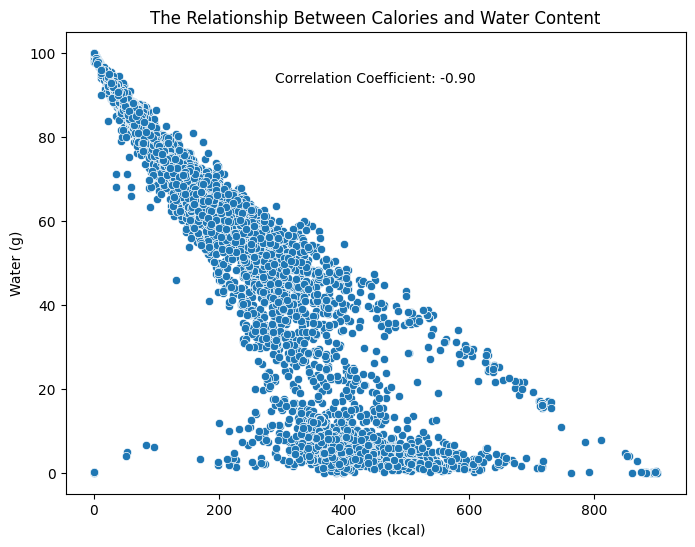

In [18]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a scatter plot
sns.scatterplot(x='Calories_kcal', y='Water_g', data=df)

# Annotate the correlation coefficient on the plot
plt.text(0.5, 0.9, f'Correlation Coefficient: {correlation_coefficient:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

# Set title and axis labels
plt.title('The Relationship Between Calories and Water Content')
plt.xlabel('Calories (kcal)')
plt.ylabel('Water (g)')

# Show the plot
plt.show()


## 3.a. Drawbacks of a zero-carb diet


No carb diet tends to have significantly higher cholesterol content, more protein and fat content; while lacks fiber and vitamins. In addition, there is not much difference in water content between zero-carb food and food that contains carb. 

A diet with surplus of cholesterol, protein and fat can cause various health problem:

Missing fiber and vitamins also causes:

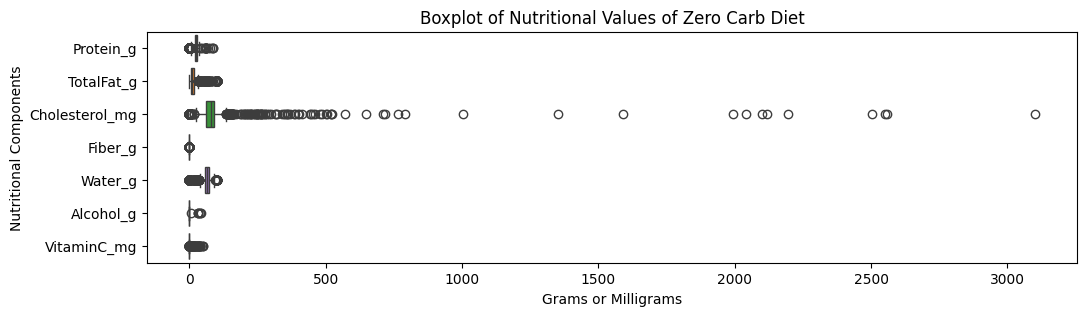

In [19]:
query = """SELECT Protein_g, TotalFat_g, Cholesterol_mg, Fiber_g, Water_g, Alcohol_g, VitaminC_mg
FROM nutrition
WHERE Carbohydrate_g = 0;"""

zero_carb = pd.read_sql(query, conn)

# Set up the matplotlib figure
plt.figure(figsize=(12, 3))

# Create a horizontally oriented boxplot using seaborn without outliers
sns.boxplot(data=zero_carb, orient='h')

# Set title and labels
plt.title('Boxplot of Nutritional Values of Zero Carb Diet')
plt.xlabel('Grams or Milligrams')
plt.ylabel('Nutritional Components')

# Show the plot
plt.show()

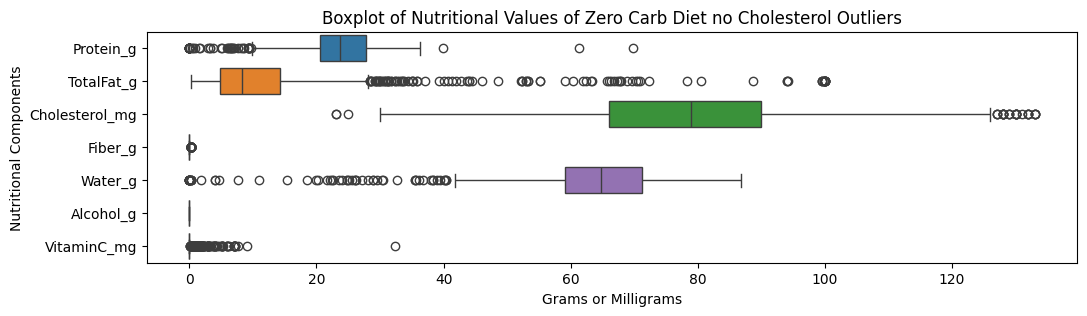

In [20]:
query = """SELECT Protein_g, TotalFat_g, Cholesterol_mg, Fiber_g, Water_g, Alcohol_g, VitaminC_mg
FROM nutrition
WHERE Carbohydrate_g = 0;"""

zero_carb = pd.read_sql(query, conn)

# Identify and remove outliers using IQR method
Q1 = zero_carb['Cholesterol_mg'].quantile(0.25)
Q3 = zero_carb['Cholesterol_mg'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
zero_carb_no_outliers = zero_carb[(zero_carb['Cholesterol_mg'] >= lower_bound) & (zero_carb['Cholesterol_mg'] <= upper_bound)]

# Set up the matplotlib figure
plt.figure(figsize=(12, 3))

# Create a horizontally oriented boxplot using seaborn without outliers
sns.boxplot(data=zero_carb_no_outliers, orient='h')

# Set title and labels
plt.title('Boxplot of Nutritional Values of Zero Carb Diet no Cholesterol Outliers')
plt.xlabel('Grams or Milligrams')
plt.ylabel('Nutritional Components')

# Show the plot
plt.show()

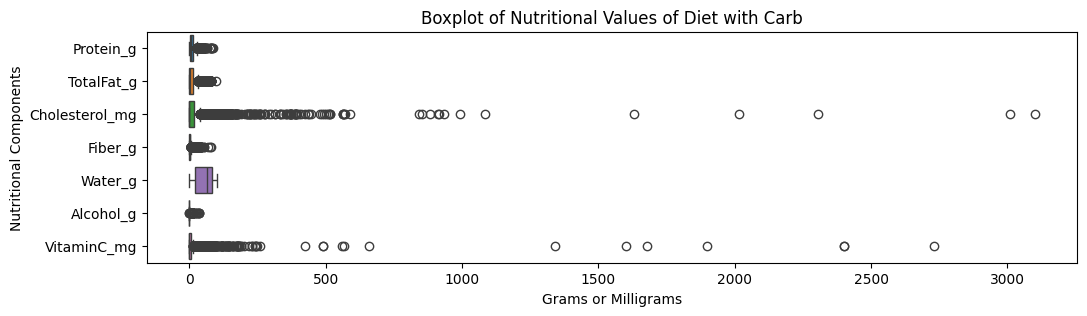

In [21]:
query = """SELECT Protein_g, TotalFat_g, Cholesterol_mg, Fiber_g, Water_g, Alcohol_g, VitaminC_mg
FROM nutrition
WHERE Carbohydrate_g != 0;"""

with_carb = pd.read_sql(query, conn)

# Set up the matplotlib figure
plt.figure(figsize=(12, 3))

# Create a horizontally oriented boxplot using seaborn without outliers
sns.boxplot(data=with_carb, orient='h')

# Set title and labels
plt.title('Boxplot of Nutritional Values of Diet with Carb')
plt.xlabel('Grams or Milligrams')
plt.ylabel('Nutritional Components')

# Show the plot
plt.show()

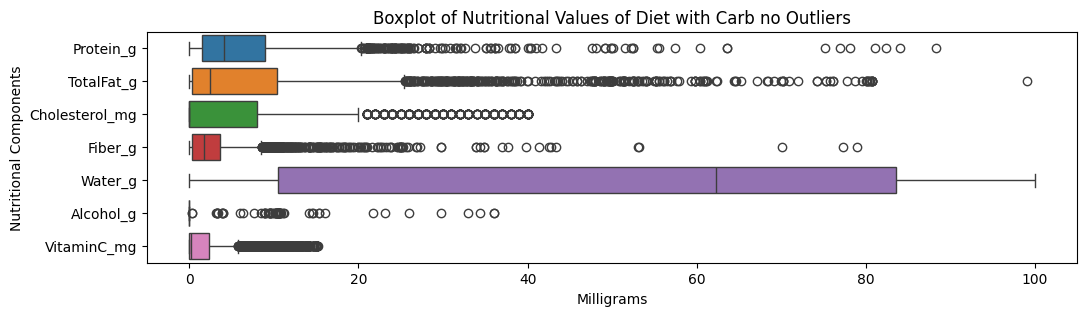

In [22]:
query = """SELECT Protein_g, TotalFat_g, Cholesterol_mg, Fiber_g, Water_g, Alcohol_g, VitaminC_mg
FROM nutrition
WHERE Carbohydrate_g != 0;"""

with_carb = pd.read_sql(query, conn)

# Identify and remove outliers using IQR method for 'Cholesterol_mg'
Q1_chol = with_carb['Cholesterol_mg'].quantile(0.25)
Q3_chol = with_carb['Cholesterol_mg'].quantile(0.75)
IQR_chol = Q3_chol - Q1_chol
lower_bound_chol = Q1_chol - 1.5 * IQR_chol
upper_bound_chol = Q3_chol + 1.5 * IQR_chol

# Identify and remove outliers using IQR method for 'VitaminC_mg'
Q1_vitc = with_carb['VitaminC_mg'].quantile(0.25)
Q3_vitc = with_carb['VitaminC_mg'].quantile(0.75)
IQR_vitc = Q3_vitc - Q1_vitc
lower_bound_vitc = Q1_vitc - 1.5 * IQR_vitc
upper_bound_vitc = Q3_vitc + 1.5 * IQR_vitc

# Filter the DataFrame to exclude outliers for both 'Cholesterol_mg' and 'VitaminC_mg'
with_carb_no_outliers = with_carb[
    (with_carb['Cholesterol_mg'] >= lower_bound_chol) & (with_carb['Cholesterol_mg'] <= upper_bound_chol) &
    (with_carb['VitaminC_mg'] >= lower_bound_vitc) & (with_carb['VitaminC_mg'] <= upper_bound_vitc)
]

# Set up the matplotlib figure
plt.figure(figsize=(12, 3))

# Create a horizontally oriented boxplot using seaborn without outliers for both 'Cholesterol_mg' and 'VitaminC_mg'
sns.boxplot(data=with_carb_no_outliers, orient='h')

# Set title and labels
plt.title('Boxplot of Nutritional Values of Diet with Carb no Outliers')
plt.xlabel('Milligrams')
plt.ylabel('Nutritional Components')

# Show the plot
plt.show()


<Figure size 1200x800 with 0 Axes>

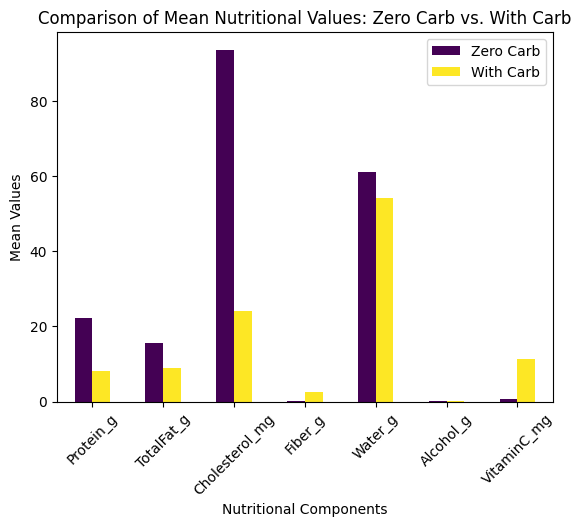

In [23]:
# Query zero_carb and with_carb 
zero_carb = pd.read_sql_query("""SELECT Protein_g, TotalFat_g, Cholesterol_mg, Fiber_g, Water_g, Alcohol_g, VitaminC_mg FROM nutrition WHERE Carbohydrate_g = 0""", conn)

with_carb = pd.read_sql_query("""SELECT Protein_g, TotalFat_g, Cholesterol_mg, Fiber_g, Water_g, Alcohol_g, VitaminC_mg FROM nutrition WHERE Carbohydrate_g != 0""", conn)

# Calculate mean values for each nutritional component
mean_values_zero_carb = zero_carb.mean()
mean_values_with_carb = with_carb.mean()

# Combine mean values into a single DataFrame
mean_comparison = pd.DataFrame({'Zero Carb': mean_values_zero_carb, 'With Carb': mean_values_with_carb})

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a bar chart comparing mean nutritional values
mean_comparison.plot(kind='bar', rot=45, colormap='viridis')

# Set title and labels
plt.title('Comparison of Mean Nutritional Values: Zero Carb vs. With Carb')
plt.xlabel('Nutritional Components')
plt.ylabel('Mean Values')

# Show the plot
plt.show()


## 3.b. Drawbacks of a very high-protein diet


The definition of a high-protein diet can vary depending on individual dietary needs, preferences, and overall diet composition. It is crucial to keep in mind that individual protein needs can vary based on factors such as age, gender, activity level, and overall health.

We can tell if a person is having a high-protein diet by gauging individual body weight and daily protein intake. A dietary intake of 1.0 g, 1.3 g, and 1.6 g protein per kg body weight per day is recommended for individuals with minimal, moderate, and intense physical activity, respectively (Wu, 2016). Meanwhile, a very high protein intake should be around 2.2 g per kg body weight per day.

In the absence of a specific body weight, this research relies on a generic standard that takes into account the portion of total calories derived from protein to define a high-protein diet. A typical diet comprises of 10%-15% of daily calories come from protein; while in a high-protein diet, this number can be as high as 30%-50%, according to an article written by the South Dakota Department of Health Office of Chronic Disease Prevention & Health Promotion in 2022. It is therefore reasonable to assume that a very high-protein diet should have more than 50% of daily calories coming from protein.

In [24]:
query = """SELECT Item, 
                  Protein_g, 
                  Calories_kcal, 
                  (Protein_g/Calories_kcal*100) AS Percentage
            FROM nutrition
            ORDER BY Percentage DESC;"""

protein = pd.read_sql(query, conn)
protein

,Item,Protein_g,Calories_kcal,Percentage
0,"Soy protein isolate, potassium type",88.32,321.0,27.514019
1,Soy protein isolate,88.32,335.0,26.364179
2,"Gelatins, dry powder, unsweetened",85.60,335.0,25.552239
3,"Beverages, Energy drink, VAULT Zero, sugar-fre...",0.25,1.0,25.000000
4,"Fish, cod, Pacific, cooked",20.42,84.0,24.309524
...,...,...,...,...
7788,"Beverages, water, bottled, non-carbonated, CRY...",0.00,0.0,NaN
7789,"Carbonated beverage, low calorie, other than c...",0.00,0.0,NaN
7790,"Babyfood, water, bottled, GERBER, without adde...",0.00,0.0,NaN
7791,"Seasoning mix, dry, sazon, coriander & annatto",0.00,0.0,NaN


## 4.a. Building a Multivariate Linear Model and Testing it

According to the Cleveland Clinic website, a gram of fat has around 9 kilocalories, and a gram of protein and a gram of carbohydrate contain 4 kilocalories each. 

What does that mean? They are the coefficients of the independent variables. In other words:
- Adding 1 gram of fat explains 9 kcal increase for a food item.
- Adding 1 gram of protein explains 4 kcal increase for a food iteam.
- Adding 1 gram of carbohydrate explains 4 kcal increase for a food iteam.

We will fit a linear model to test whether these estimates agree with the data.

In [25]:
# Separate Independent Variables and the Dependent Variable 
X = df[['Protein_g', 'Carbohydrate_g', 'TotalFat_g']]
y = df['Calories_kcal']

In [26]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Build the regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [28]:
# Display the the coefficients
print("Intercept:", lr.intercept_)

print("Coefficients:")
for name, coef in zip(X_train, lr.coef_):
    print(f"{name}: {coef}")

Intercept: 4.285088377318914
Coefficients:
Protein_g: 3.9913134609987715
Carbohydrate_g: 3.8006583058837187
TotalFat_g: 8.801033316019682


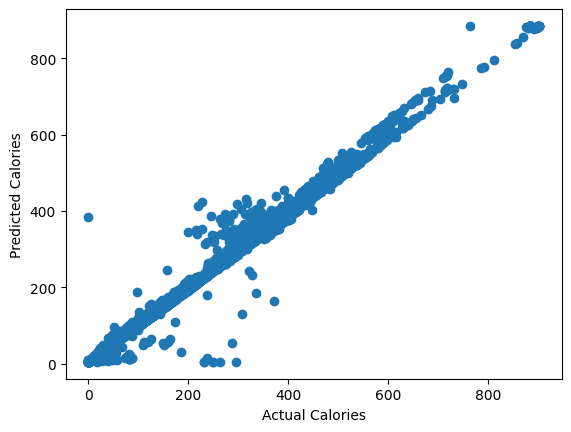

In [29]:
# Predict calories based on train dataset
y_pred_train = lr.predict(X_train)

# Visualising the corellation between actual and predict calories
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.show()

In [30]:
# Calculate R-square value of the model based on train dataset
from sklearn.metrics import r2_score

r2_score(y_train, y_pred_train)

0.9894847578351726

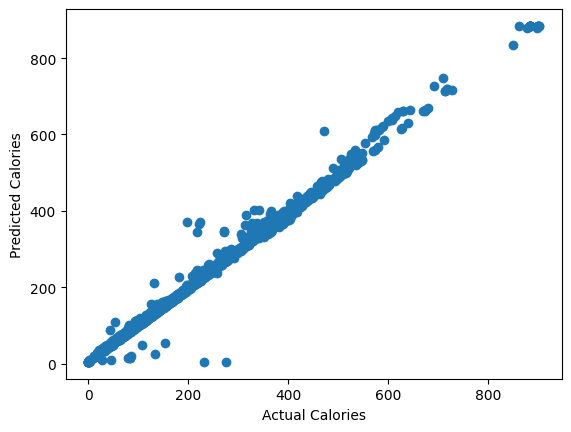

In [31]:
# Test the model by introducing test dataset
y_pred_test = lr.predict(X_test)

# Visualise the difference between actual and predicted calories of the test dataset
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.show()

In [32]:
# Calculate R-square
r2_score(y_test, y_pred_test)

0.9907501581710321

Change in independent variables (fat, protein, carbohydrate) explains 99% change in dependent varialbe (calories). The model, which has coefficients of fat, protein, carbohydrate of 9, 4, 4 (rounded to integers) respectively, works well. Data collected agrees with Cleveland Clinic's claim.

## 4.b. Checking Assumptions of the Model

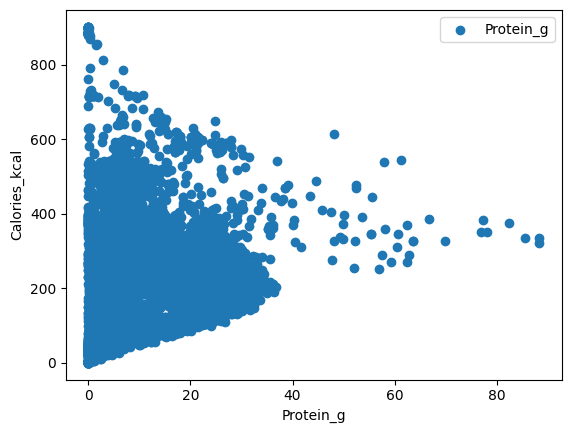

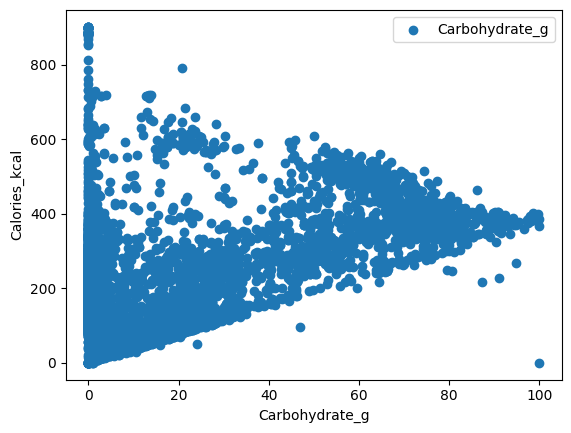

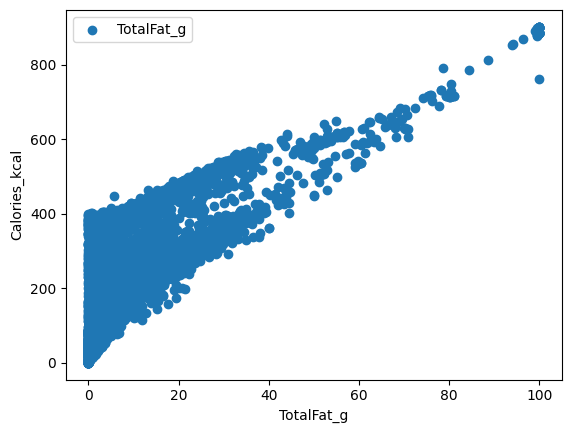

In [33]:
# Check assumptions: Linearity
for column in X_train.columns:
    plt.scatter(X_train[column], y_train, label=column)
    plt.xlabel(column)
    plt.ylabel('Calories_kcal')
    plt.legend()
    plt.show()

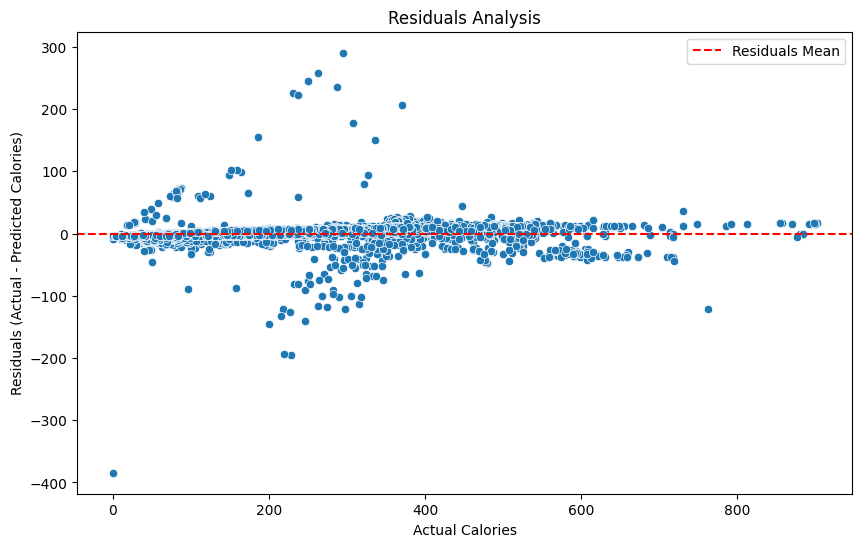

In [34]:
# Check assumptions: Homoscedasticity of residuals
# See if the difference between observed values and predicted values is significant
residuals = y_train - lr.predict(X_train)

# Plotting the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Residuals Mean')
plt.title('Residuals Analysis')
plt.xlabel('Actual Calories')
plt.ylabel('Residuals (Actual - Predicted Calories)')
plt.legend()
plt.show()

Summary Statistics of Residuals:
count    6.234000e+03
mean    -6.081899e-15
std      1.718754e+01
min     -3.843509e+02
25%     -3.517420e+00
50%     -3.511512e-01
75%      4.964213e+00
max      2.907149e+02
Name: Calories_kcal, dtype: float64


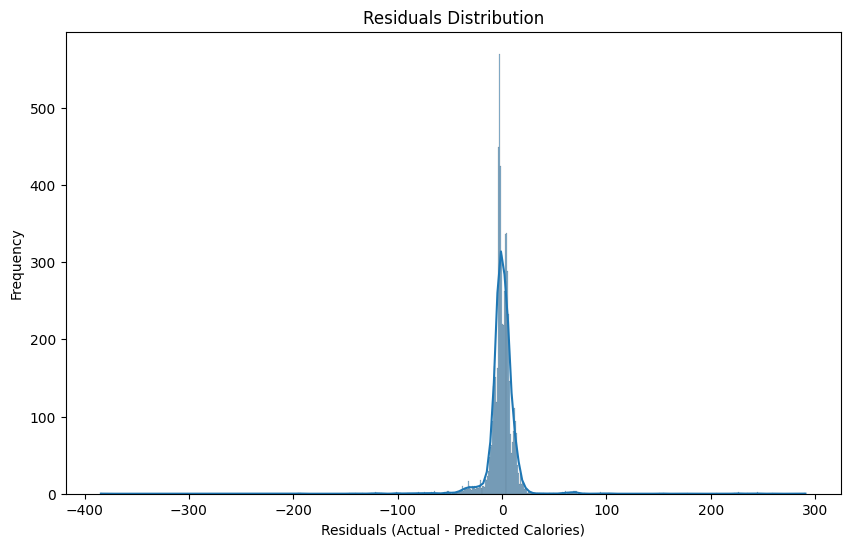

In [35]:
# Check assumptions: Normality of residuals
# Display summary statistics of residuals
print("Summary Statistics of Residuals:")
print(residuals.describe())

# Plotting residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals (Actual - Predicted Calories)')
plt.ylabel('Frequency')
plt.show()

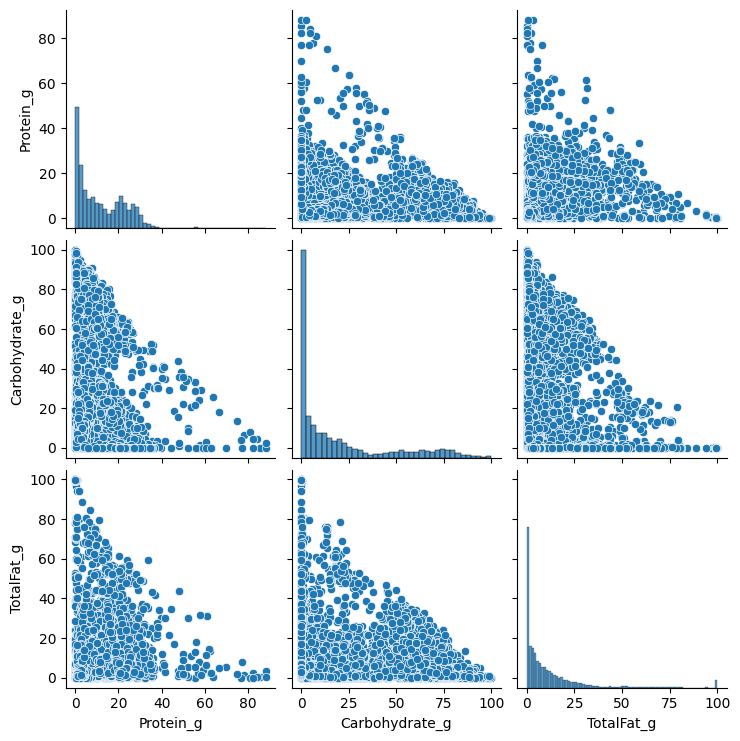

In [36]:
# #Check multicorrelation assumption
sns.pairplot(X)
plt.show()

In [37]:
# Another way to check multicorrelation
# VIF less than 10 means no significant correlation

from statsmodels.stats.outliers_influence import variance_inflation_factor
#Check multicorrelation assumption

# Create a DataFrame to calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display the VIF DataFrame
print(vif_data)

         Variable       VIF
0       Protein_g  1.280750
1  Carbohydrate_g  1.127231
2      TotalFat_g  1.284681


## 5. Hidden Sources of calories
Analyze the errors of your linear model to see what could be the hidden sources of calories in food.

# Conclusion

# Reference

Wu, G. (2016). Dietary protein intake and human health. Food & function, 7(3), 1251-1265.

Regulation (EC) No 1924/2006 of the European Parliament and of the Coucil, Annex (2006). https://eur-lex.europa.eu/eli/reg/2006/1924/oj
‌
What to Consider with a High Protein Diet | HealthySD.gov. (2022). Healthysd.gov. https://healthysd.gov/what-to-consider-with-a-high-protein-diet/

NIH https://ods.od.nih.gov/factsheets/VitaminC-HealthProfessional/
‌